# Loads the processed h5 file and plots data

debugging: the pump probe signal looks weird after implementing mpi

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [10]:
# input parameters
temperature = {
              '28 mm' : (234.7+236.3)/2,
              '35 mm' : (232.6+234.1)/2,
              '40 mm' : (231.4+232.8)/2,
              '45 mm' : (231.9+230.4)/2,
              '50 mm' : (230.8+229.5)/2,
              '55 mm' : (228.7+230)/2,
              '60 mm' : (228+229.3)/2,
              '65 mm' : (227.4-228.6)/2,
              '70 mm' : (226.8+228.1)/2,
              '75 mm' : (226.3+227.5)/2,
              '80 mm' : (225.8+227)/2,
              '85 mm' : (225.4+226.6)/2
}
run_groups = {
              '28 mm' : [109, 110, 111, 113],
              '35 mm' : [115,116,119,121,122,123],
              '40 mm' : [124,125,126],
              '45 mm' : [127,128,129,131,179,180,181],
              '50 mm' : [133,134,135,136,137,182,183],
              '55 mm' : [138,139,140,141,142,143],
              '60 mm' : [145,146,147,149],
              '65 mm' : [150,151,152,153,154,155,156],
              '70 mm' : [157,158,159,160,161,162,177,178],
              '75 mm' : [165,166,167,168,169,170,184,185,186,187,188,189,190,191,192,193],
              '80 mm' : [171,172,173],
              '85 mm' : [174,175,176]        
              }

# analysis parameters
iq_thr = 1.1

### load and analyse data

In [11]:
def analyse_run(run_num, detector_distance = 0.12, energy = 9.5, iq_thr = iq_thr, r_min = 20, r_max = 30):
    '''
    loads and analyses a single run
    '''
    
    # load data
    run_path = '/sf/bernina/data/p17743/res/work/hdf5/backup/'
    run = discover_run_h5(run_num, path=run_path)[3:-3]
    img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run, path=run_path)

    # convert q_scale
    q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

    # convert intensity to photon/pix
    Iq /=energy
    i0 /=energy

    # normalise to i0
    Iq_norm = np.zeros(Iq.shape)
    i0_avg = np.average(i0)
    norm = i0/i0_avg
    for i in range(int(nshots)):
        Iq_norm[i]=Iq[i]/norm[i]

    # hits
    metric,hits = find_hits(Iq_norm,threshold=iq_thr,r_min=30,r_max=80)
    
    # ice
    filter_length = 1      # 1 = filter off
    ice_thr = 1.0          # delta photon/pix/i0
    q_min, q_max = 1.0,4.5 # A-1
    ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, 
                                    filter_length=filter_length, q_min=q_min, q_max=q_max)

    hits *= np.logical_not(ice_hits)
    
    # weak hit rejection
    misses = np.logical_not(hits) & (i0[:nshots] > i0_avg - 2*i0[:nshots].std()) # remove weak x-ray shots (2 std)
    hits = hits & (i0[:nshots] > i0_avg - 2*i0[:nshots].std()) # remove weak x-ray shots (2 std)
    
    # laser rejection
    #l = laser_i0[laser_on.astype(np.bool)][:nshots]
    #laser_outliers = laser_on.astype(np.bool) & ((laser_i0 > (l.mean() + l.std())) | (laser_i0 < (l.mean() - l.std())))
    #hits *= np.logical_not(laser_outliers)
    
    # water hitrate
    hit_rate =len(hits[hits>0])/nshots
    
    # pump probe
    hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on,misses=misses)
    #hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on)
    #print('hits: %d, laser on: %d' % (hits.sum(), (hits & laser_on).sum()))
    return q,hit_avg,miss_avg,diff_signal,hit_rate,hits.sum(),(hits & laser_on).sum(),ice_hits.sum(),nshots



In [12]:
run_means = {}

for rg in run_groups.keys():
    
    runs = run_groups[rg]
    n = len(runs)
    data = analyse_run(runs[0])
    q = data[0]
    hit = data[1]
    miss = data[2]
    diff = data[3]
    hr = data[4]
    n_water = data[5]
    n_water_laser = data[6]
    n_ice = data[7]
    n_shots = data[8]
    
    for i in range(1,n):
        data = analyse_run(runs[i])
        hit = np.vstack([hit,data[1]])
        miss = np.vstack([miss,data[2]])
        diff = np.vstack([diff,data[3]])
        hr = np.vstack([hr,data[4]])
        n_water = np.vstack([n_water,data[5]])
        n_water_laser = np.vstack([n_water_laser,data[6]])
        n_ice = np.vstack([n_ice,data[7]])
        n_shots = np.vstack([n_shots,data[8]])
    
    run_means[rg] = [ q, (hit*n_water).sum(0)/float(n_water.sum(0)), (miss*(n_shots - n_ice - n_water)).sum(0)/float((n_shots - n_ice - n_water).sum(0)), (diff*n_water).sum(0)/float(n_water.sum(0)), (hr*n_shots).sum(0)/float(n_shots.sum(0)), n_water.sum(0), n_water_laser.sum(0), n_ice.sum(0), n_shots.sum(0) ]


run0109_droplets_10um_28mm: 18000 shots
run0110_droplets_10um_28mm: 18000 shots
run0111_droplets_10um_28mm: 18000 shots
run0113_droplets_10um_28mm: 18000 shots
run0115_droplets_10um_35mm: 18000 shots
run0116_droplets_10um_35mm: 18000 shots
run0119_droplets_10um_35mm: 18000 shots
run0121_droplets_10um_35mm: 18000 shots
run0122_droplets_10um_35mm: 18000 shots
run0123_droplets_10um_35mm: 18000 shots
run0124_droplets_10um_35mm: 18000 shots
run0125_droplets_10um_40mm: 18000 shots
run0126_droplets_10um_40mm: 18000 shots
run0127_droplets_10um_45mm: 18000 shots
run0128_droplets_10um_45mm: 18000 shots
run0129_droplets_10um_45mm: 18000 shots
run0131_droplets_10um_45mm: 18000 shots
run0179_droplets_10um_45mm: 18000 shots
run0180_droplets_10um_45mm: 18000 shots
run0181_droplets_10um_45mm: 18000 shots
run0133_droplets_10um_50mm: 18000 shots
run0134_droplets_10um_50mm: 18000 shots
run0135_droplets_10um_50mm: 18000 shots
run0136_droplets_10um_50mm: 18000 shots
run0137_droplets_10um_50mm: 18000 shots


/sf/bernina/anaconda/4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide


run0174_droplets_10um_85mm: 18000 shots
run0175_droplets_10um_85mm: 18000 shots
run0176_droplets_10um_85mm: 18000 shots


### plot

<IPython.core.display.Javascript object>


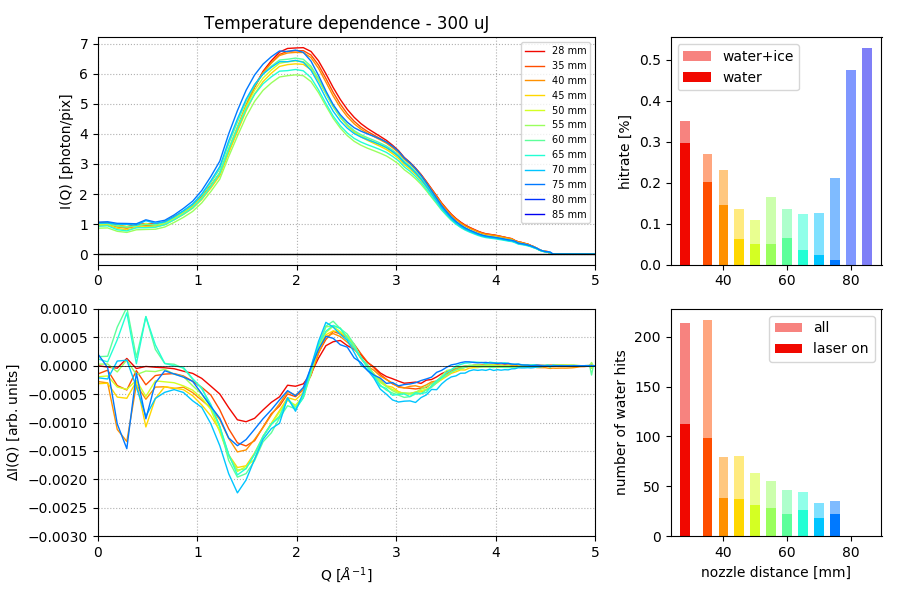

In [14]:
col = plt.cm.jet(np.linspace(0.1, 0.9, len(run_means.keys())))[::-1] 

plt.figure(figsize=[9,6])

plt.subplot2grid((2,3),(0,0),colspan=2)
plt.title('Temperature dependence - 300 uJ')
for n,rg in enumerate(run_means.keys()):
    hit  = run_means[rg][1]
    miss = run_means[rg][2]
    plt.plot(q, hit - miss, label=rg, lw=1, color=col[n])
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right',fontsize=7)
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

plt.subplot2grid((2,3),(1,0),colspan=2)
for n,rg in enumerate(run_means.keys()):
    plt.plot(q, run_means[rg][3], label=rg, lw=1, color=col[n])
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-3e-3,1e-3])
plt.xlabel('Q [$\AA^{-1}$]')
#plt.legend(loc='upper right',fontsize=6)
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=0.5)

plt.subplot2grid((2,3),(0,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), (run_means[rg][5]+run_means[rg][7])*100./run_means[rg][8], width=3, alpha=0.5, color=col[n])
    plt.bar(int(rg[:2]), run_means[rg][4]*100, width=3, color=col[n])
plt.legend(['water+ice', 'water'])
plt.ylabel('hitrate [%]')
#plt.xlabel('nozzle distance [mm]')

#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
#ax2.tick_params(axis='y', labelcolor=color)

plt.subplot2grid((2,3),(1,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), run_means[rg][5], width=3, alpha=0.5, color=col[n])
    plt.bar(int(rg[:2]), run_means[rg][6], width=3, color=col[n])
plt.legend(['all', 'laser on'])
plt.ylabel('number of water hits')
plt.xlabel('nozzle distance [mm]')

plt.tight_layout()
plt.savefig('master_plot_diff_signal_cleaned.png')
plt.show()

In [ ]:
plt.figure()
plt.plot(run_means['70 mm'][0], run_means['70 mm'][4])

In [19]:
diff

array([[  9.00845892e-04,  -3.48212261e-04,  -1.98520413e-03,
         -2.25029109e-03,  -2.70423321e-04,  -1.31037033e-03,
         -5.23095566e-04,  -3.95110096e-04,  -3.56126102e-04,
         -2.02306295e-04,  -5.62273000e-04,  -8.78089319e-04,
         -1.32758516e-03,  -1.40410253e-03,  -1.86427549e-03,
         -2.09265193e-03,  -2.24784535e-03,  -1.62613580e-03,
         -1.25052487e-03,  -9.58739939e-04,  -6.86437681e-04,
         -8.86026551e-04,  -9.39890116e-04,  -7.24140774e-04,
          8.51982576e-05,   5.18004049e-04,   8.63394969e-04,
          8.30477168e-04,   4.26310571e-04,   5.13110107e-04,
          1.19331638e-04,   1.94655171e-04,   2.38673097e-05,
         -1.93890526e-04,  -3.06468788e-04,  -5.47299079e-04,
         -3.78289016e-04,  -5.66264004e-04,  -5.49253457e-04,
         -3.36375510e-04,  -5.02143496e-04,  -3.56064516e-04,
         -3.85902873e-04,  -4.69703872e-04,  -1.12391331e-04,
         -1.81742356e-04,  -7.25378423e-05,   1.90493539e-05,
        

In [26]:
(diff*waterhits).sum(0)/float(waterhits.sum(0))

array([  2.00187976e-04,  -7.73805025e-05,  -4.41156474e-04,
        -5.00064686e-04,  -6.00940713e-05,  -2.91193407e-04,
        -1.16243459e-04,  -8.78022435e-05,  -7.91391337e-05,
        -4.49569544e-05,  -1.24949556e-04,  -1.95130960e-04,
        -2.95018924e-04,  -3.12022785e-04,  -4.14283442e-04,
        -4.65033763e-04,  -4.99521189e-04,  -3.61363511e-04,
        -2.77894415e-04,  -2.13053320e-04,  -1.52541707e-04,
        -1.96894789e-04,  -2.08864470e-04,  -1.60920172e-04,
         1.89329461e-05,   1.15112011e-04,   1.91865549e-04,
         1.84550482e-04,   9.47356824e-05,   1.14024468e-04,
         2.65181417e-05,   4.32567047e-05,   5.30384660e-06,
        -4.30867835e-05,  -6.81041752e-05,  -1.21622018e-04,
        -8.40642259e-05,  -1.25836445e-04,  -1.22056324e-04,
        -7.47501133e-05,  -1.11587444e-04,  -7.91254481e-05,
        -8.57561940e-05,  -1.04378638e-04,  -2.49758514e-05,
        -4.03871902e-05,  -1.61195205e-05,   4.23318976e-06,
         1.24463318e-05,

array([[2],
       [4],
       [0],
       [1],
       [0],
       [2]])

In [10]:
data = analyse_run(179)

OSError: Unable to open file (unable to open file: name = '/sf/bernina/data/p17743/res/work/hdf5/backup/run[].h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)